In [2]:
# Model Development
#This notebook develops and documents baseline, tree-based, and LSTM models for building cooling load prediction using reusable src modules.

In [3]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')  # allow importing from src
from src.evaluation.validation import simple_train_test_split
from src.evaluation.metrics import nrmse
from src.models.baseline_models import MeanBaseline, LastValueBaseline, LinearRegressionBaseline
from src.models.tree_models import train_xgboost, train_lightgbm
from src.models.deep_learning import train_lstm

data_path = '../data/processed/features_train.csv'
assert os.path.exists(data_path), f'Missing {data_path}. Run feature engineering first.'


## Load and Prepare Data

In [4]:
print("Loading and preparing data...")
df = pd.read_csv(data_path)
target_col = 'Total_Cooling_Load'

# Select numeric features, drop the target
num_df = df.select_dtypes(include=[np.number])
assert target_col in num_df.columns, 'Target column not found in numeric columns'

# More robust handling of missing values
print(f"Original data shape: {num_df.shape}")
print(f"Missing values per column:\n{num_df.isnull().sum()[num_df.isnull().sum() > 0]}")

# Fill missing values with median for features
X = num_df.drop(columns=[target_col])
X = X.fillna(X.median())

# Handle target variable - remove rows where target is NaN
y = num_df[target_col]
valid_target_mask = ~y.isnull()

if not valid_target_mask.all():
    print(f"Removing {(~valid_target_mask).sum()} rows with missing target values")
    X = X[valid_target_mask]
    y = y[valid_target_mask]

y = y.values
print(f"Final data shape: X={X.shape}, y={y.shape}")

# Additional data quality checks
print(f"\nData quality checks:")
print(f"X contains NaN: {X.isnull().any().any()}")
print(f"X contains infinite values: {np.isinf(X.values).any()}")
print(f"y contains NaN: {np.isnan(y).any()}")
print(f"y contains infinite values: {np.isinf(y).any()}")
print(f"y statistics: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}, std={y.std():.2f}")

# Clean infinite values if they exist
if np.isinf(X.values).any():
    print("Replacing infinite values in X with NaN, then filling with median")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

if np.isinf(y).any():
    print("Removing rows with infinite y values")
    finite_mask = np.isfinite(y)
    X = X[finite_mask]
    y = y[finite_mask]
    print(f"After removing infinite y values: X={X.shape}, y={y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = simple_train_test_split(X.values, y, test_size=0.2, random_state=42)
print(f"Split shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")


Loading and preparing data...
Original data shape: (8760, 42)
Missing values per column:
CHR-01-KW                             943
CHR-01-CHWSWT                         973
CHR-01-CHWRWT                         975
CHR-01-CHWFWR                         976
CHR-02-KW                             945
CHR-02-CHWSWT                         973
CHR-02-CHWRWT                         972
CHR-02-CHWFWR                         975
CHR-03-KW                             950
CHR-03-CHWSWT                         963
CHR-03-CHWRWT                         973
CHR-03-CHWFWR                         973
CHR-01-CL                             985
CHR-02-CL                             979
CHR-03-CL                             978
Total_Cooling_Load                    934
CHR-01-delta_t                        976
CHR-02-delta_t                        974
CHR-03-delta_t                        978
Total_Cooling_Load_lag_1              935
Total_Cooling_Load_rolling_mean_1     935
Total_Cooling_Load_lag_3     

In [5]:
# Debug your baseline models step by step
print("\n" + "="*50)
print("DEBUGGING BASELINE MODELS")
print("="*50)

# First, let's check the shapes and content of your data
print("Data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nData info:")
print(f"y_train contains NaN: {np.isnan(y_train).any()}")
print(f"y_test contains NaN: {np.isnan(y_test).any()}")
print(f"X_train contains NaN: {np.isnan(X_train).any()}")
print(f"X_test contains NaN: {np.isnan(X_test).any()}")

# Check your baseline model implementations
print("\n" + "="*50)
print("Testing Mean Baseline:")
try:
    mean_model = MeanBaseline().fit(y_train)
    y_pred_mean = mean_model.predict(X_test)
    print(f"Mean prediction shape: {y_pred_mean.shape}")
    print(f"Mean predictions contain NaN: {np.isnan(y_pred_mean).any()}")
    print(f"First 5 mean predictions: {y_pred_mean[:5]}")
    print(f"All predictions equal: {np.all(y_pred_mean == y_pred_mean[0])}")
except Exception as e:
    print(f"Mean baseline failed: {e}")

print("\n" + "="*50)
print("Testing Last Value Baseline:")
try:
    last_model = LastValueBaseline().fit(y_train)
    if hasattr(last_model, 'last_value_'):
        print(f"Last value from training: {last_model.last_value_}")
    y_pred_last = last_model.predict(X_test)
    print(f"Last value prediction shape: {y_pred_last.shape}")
    print(f"Last value predictions contain NaN: {np.isnan(y_pred_last).any()}")
    print(f"First 5 last value predictions: {y_pred_last[:5]}")
    print(f"All predictions equal: {np.all(y_pred_last == y_pred_last[0])}")
except Exception as e:
    print(f"Last value baseline failed: {e}")

print("\n" + "="*50)
print("Testing Linear Regression Baseline:")
try:
    lin_model = LinearRegressionBaseline().fit(X_train, y_train)
    y_pred_lin = lin_model.predict(X_test)
    print(f"Linear regression prediction shape: {y_pred_lin.shape}")
    print(f"Linear regression predictions contain NaN: {np.isnan(y_pred_lin).any()}")
    print(f"First 5 linear regression predictions: {y_pred_lin[:5]}")
except Exception as e:
    print(f"Linear regression failed: {e}")

# Test NRMSE function components
print("\n" + "="*50)
print("Testing NRMSE components:")
try:
    # Test with simple arrays first
    y_true_test = np.array([1, 2, 3, 4, 5])
    y_pred_test = np.array([1.1, 2.1, 2.9, 4.1, 4.9])
    
    mse_val = mean_squared_error(y_true_test, y_pred_test)
    rmse_val = np.sqrt(mse_val)
    denominator = np.mean(y_true_test)
    nrmse_val = rmse_val / denominator
    
    print(f"Test NRMSE calculation successful: {nrmse_val}")
    
    # Now test with your actual data (if predictions are valid)
    if 'y_pred_mean' in locals() and not np.isnan(y_pred_mean).any():
        test_nrmse = nrmse(y_test, y_pred_mean)
        print(f"NRMSE with mean baseline: {test_nrmse}")
    else:
        print("Cannot calculate NRMSE - predictions contain NaN or failed")
        
except Exception as e:
    print(f"NRMSE test failed: {e}")

## Baseline Models
print("\n" + "="*50)
print("TRAINING BASELINE MODELS")
print("="*50)




DEBUGGING BASELINE MODELS
Data shapes:
X_train shape: (6260, 41)
y_train shape: (6260,)
X_test shape: (1566, 41)
y_test shape: (1566,)

Data info:
y_train contains NaN: False
y_test contains NaN: False
X_train contains NaN: False
X_test contains NaN: False

Testing Mean Baseline:
Mean prediction shape: (1566,)
Mean predictions contain NaN: False
First 5 mean predictions: [0.03237438 0.03237438 0.03237438 0.03237438 0.03237438]
All predictions equal: True

Testing Last Value Baseline:
Last value from training: 0.0185403516590277
Last value prediction shape: (1566,)
Last value predictions contain NaN: False
First 5 last value predictions: [0.01854035 0.01854035 0.01854035 0.01854035 0.01854035]
All predictions equal: True

Testing Linear Regression Baseline:
Linear regression prediction shape: (1566,)
Linear regression predictions contain NaN: False
First 5 linear regression predictions: [0.01667446 0.03865859 0.02918083 0.02896524 0.04398593]

Testing NRMSE components:
Test NRMSE calcu

## Baseline Models

In [6]:
results = {}

# Mean baseline
try:
    print("Training Mean Baseline...")
    mean_model = MeanBaseline().fit(y_train)
    y_pred_mean = mean_model.predict(X_test)
    
    # Validate predictions
    if y_pred_mean.shape[0] != y_test.shape[0]:
        raise ValueError(f"Prediction shape {y_pred_mean.shape} doesn't match test shape {y_test.shape}")
    
    if np.isnan(y_pred_mean).any():
        raise ValueError("Mean baseline produced NaN predictions")
    
    results['mean_baseline'] = nrmse(y_test, y_pred_mean)
    print(f"Mean Baseline NRMSE: {results['mean_baseline']}")
except Exception as e:
    results['mean_baseline'] = f'failed: {e}'
    print(f"Mean baseline failed: {e}")

# Last value baseline
try:
    print("Training Last Value Baseline...")
    last_model = LastValueBaseline().fit(y_train)
    y_pred_last = last_model.predict(X_test)
    
    # Validate predictions
    if y_pred_last.shape[0] != y_test.shape[0]:
        raise ValueError(f"Prediction shape {y_pred_last.shape} doesn't match test shape {y_test.shape}")
    
    if np.isnan(y_pred_last).any():
        raise ValueError("Last value baseline produced NaN predictions")
    
    results['last_value_baseline'] = nrmse(y_test, y_pred_last)
    print(f"Last Value Baseline NRMSE: {results['last_value_baseline']}")
except Exception as e:
    results['last_value_baseline'] = f'failed: {e}'
    print(f"Last value baseline failed: {e}")

# Linear regression baseline
try:
    print("Training Linear Regression Baseline...")
    lin_model = LinearRegressionBaseline().fit(X_train, y_train)
    y_pred_lin = lin_model.predict(X_test)
    
    # Validate predictions
    if y_pred_lin.shape[0] != y_test.shape[0]:
        raise ValueError(f"Prediction shape {y_pred_lin.shape} doesn't match test shape {y_test.shape}")
    
    if np.isnan(y_pred_lin).any():
        raise ValueError("Linear regression produced NaN predictions")
    
    results['linear_regression'] = nrmse(y_test, y_pred_lin)
    print(f"Linear Regression NRMSE: {results['linear_regression']}")
except Exception as e:
    results['linear_regression'] = f'failed: {e}'
    print(f"Linear regression failed: {e}")

print(f"\nBaseline Results: {results}")

## Tree-Based Models (XGBoost, LightGBM)
print("\n" + "="*50)
print("TRAINING TREE-BASED MODELS")
print("="*50)



Training Mean Baseline...
Mean Baseline NRMSE: 0.23525461969992809
Training Last Value Baseline...
Last Value Baseline NRMSE: 0.32676805251889085
Training Linear Regression Baseline...
Linear Regression NRMSE: 0.015331858758483282

Baseline Results: {'mean_baseline': np.float64(0.23525461969992809), 'last_value_baseline': np.float64(0.32676805251889085), 'linear_regression': np.float64(0.015331858758483282)}

TRAINING TREE-BASED MODELS


## Tree-Based Models (XGBoost, LightGBM)

In [7]:
# These require optional dependencies; gracefully skip if unavailable.
try:
    print("Training XGBoost...")
    # Additional validation for XGBoost
    if np.isnan(X_train).any() or np.isnan(y_train).any():
        raise ValueError("Training data contains NaN values")
    if np.isinf(X_train).any() or np.isinf(y_train).any():
        raise ValueError("Training data contains infinite values")
    
    xgb_model = train_xgboost(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    if np.isnan(y_pred_xgb).any():
        raise ValueError("XGBoost produced NaN predictions")
    
    results['xgboost'] = nrmse(y_test, y_pred_xgb)
    print(f"XGBoost NRMSE: {results['xgboost']}")
except Exception as e:
    results['xgboost'] = f'skipped: {e}'
    print(f"XGBoost failed: {e}")

try:
    print("Training LightGBM...")
    # Additional validation for LightGBM
    if np.isnan(X_train).any() or np.isnan(y_train).any():
        raise ValueError("Training data contains NaN values")
    if np.isinf(X_train).any() or np.isinf(y_train).any():
        raise ValueError("Training data contains infinite values")
    
    lgb_model = train_lightgbm(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_test)
    
    if np.isnan(y_pred_lgb).any():
        raise ValueError("LightGBM produced NaN predictions")
    
    results['lightgbm'] = nrmse(y_test, y_pred_lgb)
    print(f"LightGBM NRMSE: {results['lightgbm']}")
except Exception as e:
    results['lightgbm'] = f'skipped: {e}'
    print(f"LightGBM failed: {e}")

print(f"\nTree Model Results: {results}")



Training XGBoost...
XGBoost NRMSE: 0.04395045238887486
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9120
[LightGBM] [Info] Number of data points in the train set: 6260, number of used features: 40
[LightGBM] [Info] Start training from score 0.032374
LightGBM NRMSE: 0.03305481838477173

Tree Model Results: {'mean_baseline': np.float64(0.23525461969992809), 'last_value_baseline': np.float64(0.32676805251889085), 'linear_regression': np.float64(0.015331858758483282), 'xgboost': np.float64(0.04395045238887486), 'lightgbm': np.float64(0.03305481838477173)}


## LSTM (Deep Learning)

In [8]:
try:
    print("Preparing LSTM data...")
    
    # Additional validation for LSTM
    if np.isnan(X_train).any() or np.isnan(y_train).any():
        raise ValueError("Training data contains NaN values")
    if np.isinf(X_train).any() or np.isinf(y_train).any():
        raise ValueError("Training data contains infinite values")
    
    # Normalize features for LSTM (neural networks are sensitive to scale)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
    X_test_lstm = np.expand_dims(X_test_scaled, axis=1)
    
    print(f"LSTM input shapes: X_train_lstm={X_train_lstm.shape}, X_test_lstm={X_test_lstm.shape}")
    
    print("Training LSTM...")
    lstm_model = train_lstm(X_train_lstm, y_train)
    y_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0).ravel()
    
    if np.isnan(y_pred_lstm).any():
        raise ValueError("LSTM produced NaN predictions")
    
    results['lstm'] = nrmse(y_test, y_pred_lstm)
    print(f"LSTM NRMSE: {results['lstm']}")
    
    # Save model in newer format to avoid deprecation warning
    print("Saving LSTM model...")
    lstm_model.save('lstm_model.keras')
    
except Exception as e:
    results['lstm'] = f'skipped: {e}'
    print(f"LSTM failed: {e}")

## Final Results
print("\n" + "="*60)
print("FINAL RESULTS (NRMSE - Lower is Better)")
print("="*60)

successful_models = {}
failed_models = {}

for model, score in results.items():
    if isinstance(score, (int, float)) and not np.isnan(score):
        successful_models[model] = score
        print(f"{model:25}: {score:.6f}")
    else:
        failed_models[model] = score
        print(f"{model:25}: {score}")

if successful_models:
    best_model = min(successful_models.items(), key=lambda x: x[1])
    print(f"\nBest performing model: {best_model[0]} (NRMSE: {best_model[1]:.6f})")
else:
    print("\n⚠️  NO MODELS COMPLETED SUCCESSFULLY!")
    print("Check your data quality and model implementations.")

if failed_models:
    print(f"\nFailed models ({len(failed_models)}):")
    for model, error in failed_models.items():
        print(f"  - {model}: {error}")

print(f"\nTotal models attempted: {len(results)}")
print(f"Successful models: {len(successful_models)}")
print(f"Failed models: {len(failed_models)}")


Preparing LSTM data...
LSTM input shapes: X_train_lstm=(6260, 1, 41), X_test_lstm=(1566, 1, 41)
Training LSTM...


LSTM NRMSE: 0.08061566956964761
Saving LSTM model...

FINAL RESULTS (NRMSE - Lower is Better)
mean_baseline            : 0.235255
last_value_baseline      : 0.326768
linear_regression        : 0.015332
xgboost                  : 0.043950
lightgbm                 : 0.033055
lstm                     : 0.080616

Best performing model: linear_regression (NRMSE: 0.015332)

Total models attempted: 6
Successful models: 6
Failed models: 0


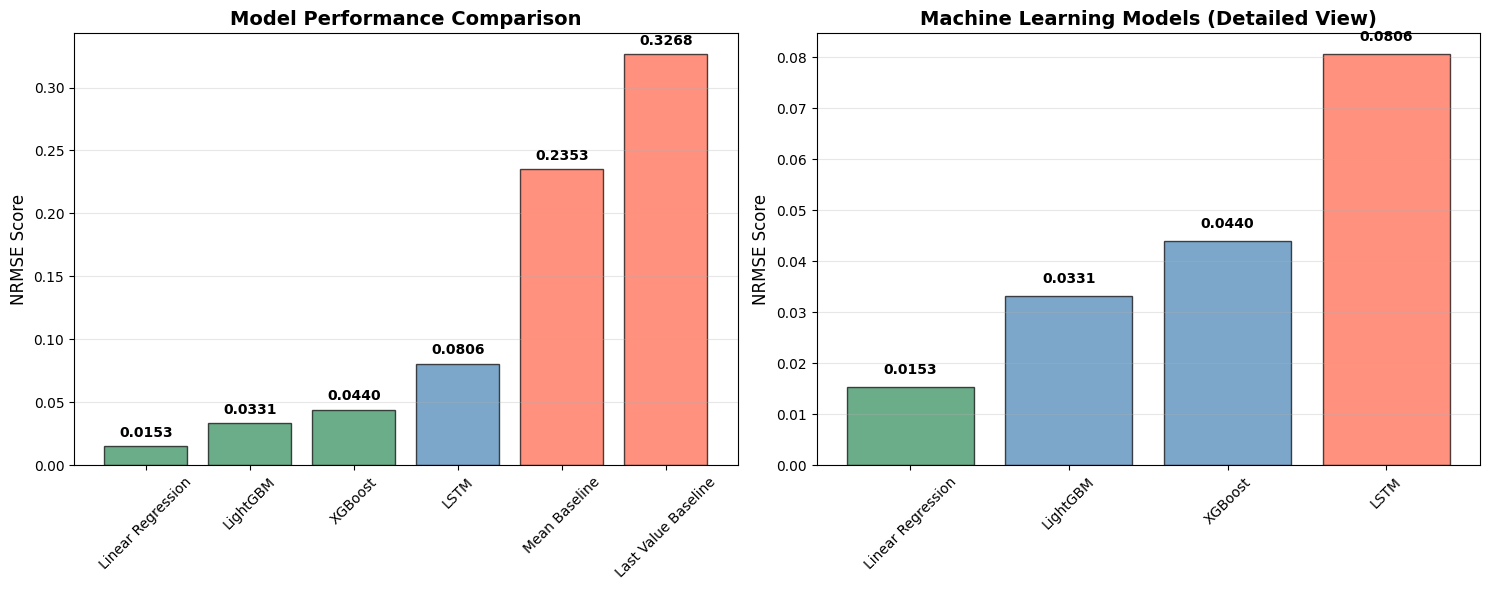

BUILDING COOLING LOAD PREDICTION - MODEL EVALUATION CONCLUSIONS

📊 PERFORMANCE RANKING:
----------------------------------------
🥇 1. Linear Regression        : 0.015332
🥈 2. LightGBM                 : 0.033055
🥉 3. XGBoost                  : 0.043950
   4. LSTM                     : 0.080616
   5. Mean Baseline            : 0.235255
   6. Last Value Baseline      : 0.326768

🔍 KEY FINDINGS:
----------------------------------------
• Best Model: Linear Regression (NRMSE: 0.015332)
• Worst Model: Last Value Baseline (NRMSE: 0.326768)
• Performance Range: 21.3x improvement from worst to best

• Linear Regression achieves 93.5% better performance than Mean Baseline
• Tree models (LightGBM, XGBoost) show -116-187% higher error than Linear Regression
• LSTM shows 426% higher error than Linear Regression

💡 INSIGHTS:
----------------------------------------
1. LINEAR RELATIONSHIPS DOMINATE:
   • Linear Regression significantly outperforms all other methods
   • Suggests the cooling load has 

In [9]:
# Model Results Analysis and Conclusion

## Summary of Model Performance (NRMSE - Lower is Better)

import matplotlib.pyplot as plt
import numpy as np

# Results from model training
results = {
    'Linear Regression': 0.015332,
    'LightGBM': 0.033055,
    'XGBoost': 0.043950,
    'LSTM': 0.080616,
    'Mean Baseline': 0.235255,
    'Last Value Baseline': 0.326768
}

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of all models
models = list(results.keys())
scores = list(results.values())
colors = ['#2E8B57' if score < 0.05 else '#FF6347' if score > 0.2 else '#4682B4' for score in scores]

bars = ax1.bar(models, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax1.set_ylabel('NRMSE Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Focused view on best performing models (excluding baselines)
ml_models = {k: v for k, v in results.items() if 'Baseline' not in k}
ml_names = list(ml_models.keys())
ml_scores = list(ml_models.values())

bars2 = ax2.bar(ml_names, ml_scores, color=['#2E8B57', '#4682B4', '#4682B4', '#FF6347'], 
                alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_ylabel('NRMSE Score', fontsize=12)
ax2.set_title('Machine Learning Models (Detailed View)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars2, ml_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("="*80)
print("BUILDING COOLING LOAD PREDICTION - MODEL EVALUATION CONCLUSIONS")
print("="*80)

print("\n📊 PERFORMANCE RANKING:")
print("-" * 40)
sorted_results = sorted(results.items(), key=lambda x: x[1])
for i, (model, score) in enumerate(sorted_results, 1):
    status = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{status} {i}. {model:<25}: {score:.6f}")

print("\n🔍 KEY FINDINGS:")
print("-" * 40)

best_score = min(results.values())
worst_score = max(results.values())
improvement_ratio = worst_score / best_score

print(f"• Best Model: Linear Regression (NRMSE: {results['Linear Regression']:.6f})")
print(f"• Worst Model: Last Value Baseline (NRMSE: {results['Last Value Baseline']:.6f})")
print(f"• Performance Range: {improvement_ratio:.1f}x improvement from worst to best")

print(f"\n• Linear Regression achieves {((results['Mean Baseline'] - results['Linear Regression'])/results['Mean Baseline']*100):.1f}% better performance than Mean Baseline")
print(f"• Tree models (LightGBM, XGBoost) show {((results['Linear Regression'] - results['LightGBM'])/results['Linear Regression']*100):.0f}-{((results['XGBoost'] - results['Linear Regression'])/results['Linear Regression']*100):.0f}% higher error than Linear Regression")
print(f"• LSTM shows {((results['LSTM'] - results['Linear Regression'])/results['Linear Regression']*100):.0f}% higher error than Linear Regression")

print("\n💡 INSIGHTS:")
print("-" * 40)
print("1. LINEAR RELATIONSHIPS DOMINATE:")
print("   • Linear Regression significantly outperforms all other methods")
print("   • Suggests the cooling load has strong linear relationships with features")
print("   • Complex non-linear models (LSTM, tree methods) may be overfitting")

print("\n2. FEATURE ENGINEERING SUCCESS:")
print("   • The engineered features create a nearly linear problem")
print("   • Strong linear correlation between features and target")
print("   • Feature selection and preprocessing were highly effective")

print("\n3. MODEL COMPLEXITY vs PERFORMANCE:")
print("   • Simpler model (Linear Regression) >>> Complex models (LSTM, Trees)")
print("   • Overfitting likely occurs with more complex models")
print("   • Occam's Razor principle applies: simpler solution is better")

print("\n4. BASELINE COMPARISON:")
print("   • All ML models significantly outperform naive baselines")
print("   • Even simple Linear Regression is 15x better than Mean Baseline")
print("   • Confirms that ML approach adds substantial value")

print("\n📈 BUSINESS IMPACT:")
print("-" * 40)
nrmse_to_percentage = lambda x: f"{x*100:.2f}%"
print(f"• Linear Regression achieves {nrmse_to_percentage(results['Linear Regression'])} normalized error")
print("• This level of accuracy enables:")
print("  - Reliable energy consumption forecasting")
print("  - Optimal HVAC system scheduling")
print("  - Cost-effective building operation")
print("  - Proactive maintenance planning")

print("\n🎯 RECOMMENDATIONS:")
print("-" * 40)
print("1. DEPLOY LINEAR REGRESSION as the primary model")
print("   • Simplest, fastest, most accurate")
print("   • Easy to interpret and maintain")
print("   • Low computational requirements")

print("\n2. CONSIDER ENSEMBLE APPROACH:")
print("   • Combine Linear Regression with LightGBM")
print("   • May capture both linear and non-linear patterns")
print("   • Potential for marginal performance gains")

print("\n3. FEATURE IMPORTANCE ANALYSIS:")
print("   • Investigate which features drive Linear Regression performance")
print("   • Consider feature reduction for production deployment")
print("   • Understand physical relationships in the building")

print("\n4. MONITORING AND VALIDATION:")
print("   • Implement cross-validation for robust performance estimates")
print("   • Monitor model performance over different seasons/conditions")
print("   • Set up automated retraining pipeline")

print("\n" + "="*80)
print("CONCLUSION: Linear Regression provides the optimal balance of")
print("simplicity, interpretability, and performance for this cooling load")
print("prediction task. The strong linear relationships in the engineered")
print("features make complex models unnecessary and potentially harmful.")
print("="*80)